# Exercise 4 - 量子化学 - 電子構造計算

## 背景

量子コンピューティングは、将来革新的なハイ・パフォーマンス・コンピューティングを持ち、現在の古典コンピューティングの能力を多くの分野において凌駕する大きな可能性を持ちます。化学は、量子コンピューティングにおいて最も有望なアプリケーションの一つです。特に、化学反応をよく理解するため、また、新しい薬品や新材料をデザインするために、分子の電子構造をシミュレーションすることは、近い将来の量子コンピューターの主な応用例のうちの一つです。

変分量子固有値ソルバー(Variational Quantum Eigensolver, VQE)は、近未来の量子コンピューターを用いた量子化学の主力アルゴリズムです。またVQEは、分子システムの基底状態エネルギー（最も小さいエネルギー）を求める量子・古典ハイブリッドアルゴリズムです。
このアルゴリズムは、2014年にAlberto Peruzzoと共同執筆者 [1] によって初めて公開され、2017年にIBM Quantumで小さな分子の基底状態エネルギーをシミュレートする際に使われました[2] 。
基底状態のエネルギーを得ることは、化学反応の理解と研究につながり、様々な分子の特性についてさらに洞察を得ることができます。例えば、原子核にかかる正確な力など、分子動力学シミュレーションを実行して、時間と共に化学システムで何が起こるのか調べるのに役立ちます。[3]

VQEアルゴリズムは、試行波動関数（ansatz）と呼ばれるパラメーター化された量子回路と調整可能なパラメーターの準備から始め、最小のエネルギーが得られるまで古典最適化によって繰り返しパラメーターを更新します。量子計算ユニットでは問題としている波動関数を古典コンピューターより効率的に表現でき、保持できる点で、VQEは古典アルゴリズムより優っています。

量子運動方程式(quantum Equation Of Motion、qEOM)アルゴリズムは、分子の励起エネルギー（基底状態と励起状態のエネルギーの差、または電子遷移エネルギー）を求めるためにVQEを拡張したものです。[4]

このExerciseでは、Qiskit Natureの様々なツールで、VQEやqEOMの方法で、水分子をシミュレーションし、その基底状態や励起状態エネルギーを計算します。

### 参考文献

1. Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." Nature communications 5.1 (2014): 1-7.
2. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246.
3. Sokolov, Igor O., et al. "Microcanonical and finite-temperature ab initio molecular dynamics simulations on quantum computers." Physical Review Research 3.1 (2021): 013125.
4. Ollitrault, Pauline J., et al. "Quantum equation of motion for computing molecular excitation energies on a noisy quantum processor." Physical Review Research 2.4 (2020): 043140.

In addition, a review on VQE: Cerezo, M., et al. "Variational quantum algorithms." Nat Rev Phys 3, 625–644 (2021). 

## はじめに

ノイズのある量子コンピューターにおいてVQEアルゴリズムを実行する際に最も重要なタスクの一つは、量子リソース(量子ビット数、量子ゲート数、測定回数)を最小化することで計算コストを減らすことです。その結果、計算誤差を最小限に抑えることができるのです。よって、目的は、基底状態を正確に表現する、最も小さく最適な量子回路を構築することです。

<div class="alert alert-block alert-success">

<b>Goal</b> 

最初に、Qiskit Natureで電子構造の問題をどのように定義するかを学びます。次に、水分子の基底状態を概算するための最も効率的なanzatzを探します。最後に、基底状態の結果を使って励起状態計算を実行します。
    
<b>Plan</b> 
        

**Part 1: 水分子のVQE :** VQEに慣れ、statevectorシミュレーターを走らせ、anzatzと古典オプティマイザーのベストな組み合わせを探します。
    
**Part 2: 水分子のqEOM :** 基底状態計算を拡張し、この水分子の電子遷移エネルギーを探します。古典的に得られた結果と量子アルゴリズムの結果を比べる方法を学びます。

</div>


<div class="alert alert-block alert-danger">

VQEシミュレーションの元となる理論を以下に紹介します。始める前に全てを理解する必要はありません。怖がらないでください！

</div>



## 理論

### 量子と古典


下図に量子コンピューター上でVQEを使って分子シミュレーションを行う一般的なワークフローを示します。

<img src="resources/workflow.png" width=600/>

量子-古典のハイブリッド手法のアイディアのコアは、 **CPU(古典プロセッシング・ユニット)** と **QPU(量子プロセッシング・ユニット)** にそれぞれベストな計算ができる部分をアウトソースすることです。
CPUでは、エネルギー計算のために測定する必要のある項目をリストすること、また回路のパラメーターを最適化することを担当します。QPUは、システムの量子状態を表現する量子回路を実装し、エネルギーを測定します。

例えば、 **CPU** は、問題を再表現し簡略化するのに役立つ、関数のセット（軌道とも呼ばれます）を見つけるために使います。実際には、これらの軌道は、[Hartree–Fock (HF) method](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method#:~:text=In%20computational%20physics%20and%20chemistry,system%20in%20a%20stationary%20state.)によって見つけることができます。この手法のより詳細な情報が以下に紹介されています。

HF計算の結果得られる軌道の基底によって、ハミルトニアンは表されます。その後、フェルミオン-量子ビット変換によって、量子ビットハミルトニアンにマップされます（下のハミルトニアンの章を参照ください）。量子ビット数を減らすこと、またansatz回路を短くすることによって、システムの特性をより詳しく分析することができます：

- Z2シンメトリーと2量子ビット削減については、こちらを参照ください：[Bravyi *et al*, 2017](https://arxiv.org/abs/1701.08213v1)
- エンタングルメント・フォージングについては、こちらを参照ください：[Eddins *et al.*, 2021](https://arxiv.org/abs/2104.10220v1)
- アダプティブAnsatzについては、こちらを参照ください：[Grimsley *et al.*,2018](https://arxiv.org/abs/1812.11173v2), [Rattew *et al.*,2019](https://arxiv.org/abs/1910.09694), [Tang *et al.*,2019](https://arxiv.org/abs/1911.10205)　量子回路を短くする手法を発見した研究のアイディアを使うことができるでしょう。

**QPU** は、量子回路を実装するために使われ(Anstaz(試行波動関数)の章を参照ください)、角度$\vec\theta$によってパラメーター化されます。目的は、正しい基底状態の波動関数を最もよく近似する(エネルギーを最小化する)角度のセットを探すことです。異なる演算子の期待値は、QPUにおいて準備されたansatzで測定できます。

以下に、VQEとqEOMアルゴリズムの各構成要素について少し数学的な詳細を見ていきます。このビデオを見ることも役に立つでしょう：[video episode about VQE](https://www.youtube.com/watch?v=Z-A6G0WVI9w)


### ハートリー・フォック
 
ハートリー・フォック理論は、システムの多体電子波動関数が一電子分子による1つのスレーター行列式によって表現されるという仮定に基づいています。

電子は、区別のつかないフェルミオンです。このことは、2つの電子の並び順を変えると波動関数の符号が変わることを意味します(これはパウリの排他原理と呼ばれる非常に重要な制約であり、周期表が特別な構造をしている理由です)。

私たちは電子の波動関数をいつも以下のように書きます：

\begin{equation}
\psi_{\text{elec}}(\mathbf{r}_1, \mathbf{r}_2, ...,\mathbf{r}_n) = \sum_{m_1, m_2,...,m_N} C_{m_1, m_2, ..., m_N} | \phi_{m_1}(\mathbf{r}_1) \phi_{m_2}(\mathbf{r}_2) ... \phi_{m_n}(\mathbf{r}_n) |
\end{equation}

ここで$C_{m_1, m_2, ..., m_N}$は、複素係数で、$| \phi_{m_1}(\mathbf{r}_1) \phi_{m_2}(\mathbf{r}_2) ... \phi_{m_n}(\mathbf{r}_n) |$はスレーター行列式であり、$\phi_{m_i}(\mathbf{r_i})$は一電子関数です。この一電子関数は<b>分子軌道 (molecular orbitals、MO)</b>と呼ばれます。MOは有名なハートリー・フォック(HF)法で計算されます。通常、MOは<b> 原子軌道 (atomic orbitals、AO) </b>で展開されます：

\begin{equation}
\phi(\mathbf{r}, s) = \sum_n D_{mn}\chi_n(\mathbf{r})\otimes s
\end{equation}

($s$ はスピン変数で$s \in \{ \alpha, \beta \}$です。）
MOは、反対のスピンを持つ2つの電子を持ち(上向きスピン($\alpha$) または下向きスピン($\beta$))、埋められているか(占有されている)または空(virtual)です。分子軌道におけるスピン構造はスピン軌道(spin orbital、SO)とも呼ばれます。量子コンピューターのために化学の問題をジョルダン・ウィグナー変換を使って変換した場合、1つの量子ビットは1つのスピン軌道を表します。

ハートリー・フォック法は、<b>1つのスレーター行列式</b>($\psi_{\text{elec}}(\mathbf{r}_1, \mathbf{r}_2, ...,\mathbf{r}_n) = | \phi_{m_1}(\mathbf{r}_1) \phi_{m_2}(\mathbf{r}_2) ... \phi_{m_n}(\mathbf{r}_n) |$) として表される電子波動関数がエネルギーを最小化するように係数$D_{mn}$を最適化します。この係数の値は、電子のシュレディンガー方程式のさらに良い近似を与える、より精巧な理論的手法に対する良いスタートポイントとなります。ハートリー・フォック法はエネルギーを最小化し、この「最適な1つの行列式」を与えるMOのセットを決定します。

AOは原子を中心とした関数です。AOは、それ自体が<b> 基底関数の集合 </b>を作る関数として展開されます。基底関数は、量子化学においては、原子を中心としたガウス関数に、原子に対する電子の座標の多項式関数$P_l$をかけたものの和として扱われます：

\begin{equation}
\chi_n(\mathbf{r}) = \sum_l N_l^n \exp\big( - \alpha_l^n (|\mathbf{r} - \mathbf{R}_I^n|^2)\big) P_l(\mathbf{r} - \mathbf{R}_I^n)
\end{equation}

$\alpha_l^n$の選択と多項式の次数が<b> 基底関数のセット </b>(様々な名前を持ちます。有名なものは6-31G, cc-pVQZ, TZ2P...など)を決定づけます。

基底関数のセットによって(粒子数とともに)AOの総数が決まります。同じ分子に対しても、違う基底関数セットを使うとAO数が変わり、そしてMO数も変わります。

基底関数のタイプはまた精度にも影響します。一つの基底関数が未知関数の再現性に優れていればいるほど、特定のレベルの精度を得るために必要な基底関数は少なくなります。基底関数が少ないほど、MOの表現が貧弱になります。

### 分子ハミルトニアン

システムのハミルトニアンは、そのシステムの総エネルギーに相当する演算子です。分子ハミルトニアンは以下のように定義されます：

$$
\hat{H} =\sum_{r s} h_{r s} \hat{a}_{r}^{\dagger} \hat{a}_{s}
+\frac{1}{2} \sum_{p q r s} g_{p q r s} \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}+E_{N N}
$$
ここで
$$
h_{p q}=\int \phi_{p}^{*}(r)\left(-\frac{1}{2} \nabla^{2}-\sum_{I} \frac{Z_{I}}{R_{I}-r}\right) \phi_{q}(r)
$$
$$
g_{p q r s}=\int \frac{\phi_{p}^{*}\left(r_{1}\right) \phi_{q}^{*}\left(r_{2}\right) \phi_{r}\left(r_{2}\right) \phi_{s}\left(r_{1}\right)}{\left|r_{1}-r_{2}\right|} 
$$

$h_{r s}$と$g_{p q r s}$ は、一電子・二電子積分(ハミルトニアンの項はHF計算から得られる軌道を表現する)であり、$E_{N N}$は原子核の反発エネルギーです。一電子積分は電子の運動エネルギーと原子核との相互作用を表します。二電子積分は、電子電子間相互作用を表します。$\hat{a}_{r}^{\dagger} / \hat{a}_{r}$演算子はスピン軌道$r$において電子を生成/消滅させます。生成/消滅演算子は、パウリ演算子に変換される必要があり、変換することで量子コンピューター上で期待値として測定できるようになります。VQEは電子のエネルギーを最小化するため、総エネルギーを得るためには、原子核の反発エネルギー$E_{NN}$を取って置き、最後に加えなければならないことを覚えておいてください。
    
### ハミルトニアンの変換

$ h_{r s}$と $g_{p q r s}$のテンソルの全てのゼロでない行列要素において、以下のフェルミオン・量子ビット変換則に従って、対応するパウリ・ストリング(パウリ演算子のテンソル積)を構築できます。例えば、$r = 3$の軌道ジョルダン・ウィグナー変換では、以下のパウリ・ストリングになります：

$$
\hat a_{3}^{\dagger}= \hat \sigma_z \otimes \hat \sigma_z \otimes\left(\frac{ \hat \sigma_x-i \hat \sigma_y}{2}\right) \otimes 1 \otimes \cdots \otimes 1
$$
ここで、$\hat \sigma_x, \hat \sigma_y, \hat \sigma_z$はよく知られているパウリ演算子です。$\hat \sigma_z$演算子のテンソル積は、フェルミオンの反交換関係を強制するために置かれます。水分子の14スピン軌道と14量子ビットとの間のジョルダン・ウィグナー変換は以下のように与えられます：

<img src="resources/mapping.png" width=600/>


次に、ハミルトニアンにおける一電子/二電子励起(e.g. $\hat{a}_{r}^{\dagger} \hat{a}_{s}$, $\hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}$)を単純にパウリ・ストリング(つまり上の図の$\hat{P}_i$)に置き換えます。その結果得られる演算子のセットは、QPUにおいて測定可能になっています。さらに詳しい説明は、こちらをご覧ください： [Seeley *et al.*, 2012](https://arxiv.org/abs/1208.5986v1)


### 活性空間(Active Space)選択

いくつかの分子システムにおいては、化学の本質を捉えるために、軌道全てを考慮する必要はありません。実際、化学的な直感を働かせ、システムのエネルギーを決定する上で最も重要な役割を果たす軌道のサブセットを選択することができるのです。この概念は<b>活性空間(Active Space)</b>選択として知られていて、量子化学の問題のサイズとコストを削減してくれます。

下の図に書かれているように、量子コンピューターにおいて全ての軌道をシミュレーションする(左の図)代わりに、VQE(青で示されている)を使って量子コンピューター上でシミュレートするいくつかの軌道として活性空間(右の図)を構築します。その一方で、残りは古典的手法(黄色で示されている)を使って近似されます。

</div>
<div style="float: right; width: 50%; padding-right=20px;">
    <img src="resources/active_space.png" width="300"/>
</div>

一般的に、最も良い活性空間を選ぶことは、挑戦的な課題です。しかし、活性空間の選択は、信頼できる波動関数を得るため、またそれに対応するエネルギーを得るために重要です。


### Ansätze(試行波動関数)

主に2つの種類のansatz(試行波動関数)を化学の問題に使うことができます。

- **q-UCC ansatz** は、物理的に発想され、電子の励起を量子回路に大まかに変換するものです。q-UCCSD ansatz(Qiskitでは`UCCSD`)は、全ての可能な一電子励起と二電子励起を含みます。これらの励起の一部のみを考慮した(つまり大幅に回路が短い)、ペアで二電子励起のq-pUCCD (`PUCCD`)とシングルで二電子励起のq-UCCD0 (`SUCCD`) は、解離プロファイルにおいて良い結果を与えることが証明されています。例えば、q-pUCCDは、下の図のように一電子励起を含まず、二電子励起がペアになっています。
 
- **経験的なansatz(`TwoLocal`)** は、回路の深さ(Depth)を短くするために発明されましたが、この短い回路を使っても基底状態を表現できます。  下の図にあるように、パラメーター化されたRゲートによる1量子ビットの回転と、２量子ビットゲートによる$U_{CNOT}$ のエンタングラーがあります。（独立なパラメーターを使って）この同じブロックを$D$回繰り返した後に、基底状態に達するというアイディアです。

より詳しい説明はこちらをご覧ください：[Sokolov *et al.* (q-UCC ansatzes)](https://arxiv.org/abs/1911.10864v2)、[Barkoutsos *et al.* (Heuristic ansatzes)](https://arxiv.org/pdf/1805.04340.pdf)

<img src="resources/ansatz.png" width=700/>



### 全てをまとめる：変分量子固有値ソルバー (VQE)

ハミルトニアン演算子$\hat H$が、固有ベクトル$|\psi_{min}\rangle$に関連付けられた未知の最小固有値$E_{min}$を持つとして与えられた時、VQEは、$E_{\theta}$を推定し、その最小値は、$E_{min}$です：

\begin{align*}
    E_{min} \le E_{\theta} \equiv \langle \psi(\theta) |\hat H|\psi(\theta) \rangle
\end{align*}  

ここで、$|\psi(\theta)\rangle$は、$E_{\theta}$に関連付けられたansatz(試行波動関数)です。$U(\theta)$で表された、パラメーター化された回路を任意の初期状態$|\psi\rangle$に対して適用することによって、アルゴリズムは、$U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle$を$|\psi_{min}\rangle$に推定します。推定は、古典オプティマイザーによってパラメーター$\theta$を変え、期待値$\langle \psi(\theta) |\hat H|\psi(\theta) \rangle$を最小化するように、繰り返し最適化されます。


VQEの応用として、分子動力学シミュレーションにおける可能性についてはこちら[Sokolov *et al.*, 2021](https://arxiv.org/abs/2008.08144v1)をご覧ください。また励起状態の計算については、こちら[Ollitrault *et al.*, 2019](https://arxiv.org/abs/1910.12890)にいくつか例があります。

<div class="alert alert-block alert-danger">
 
<b> より詳細な説明 </b> 

このアルゴリズムを実装した、Qiskit Natureのチュートリアルは[こちら](https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html)にありますが、十分ではないので、[githubレポジトリーの最初のページ](https://github.com/Qiskit/qiskit-nature)と[テストフォルダー](https://github.com/Qiskit/qiskit-nature/tree/main/test) をご覧になることをお勧めします。各コンポーネントに対するテストがあり、各機能の基本となるコードが置かれています。 
    

</div>


### 量子運動方程式 (qEOM)

励起エネルギーは、量子運動方程式(qEOM)アルゴリズム[Phys. Rev. Research 2, 043140]を使って解くことができます。EOM法は励起エネルギー(基底状態と全ての$n$番目の励起状態との間のエネルギー差)を以下の擬似固有値問題を解くことで見つけます。

$$
\begin{pmatrix}
    \text{M} & \text{Q}\\ 
    \text{Q*} & \text{M*}
\end{pmatrix}
\begin{pmatrix}
    \text{X}_n\\ 
    \text{Y}_n
\end{pmatrix}
= E_{0n}
\begin{pmatrix}
    \text{V} & \text{W}\\ 
    -\text{W*} & -\text{V*}
\end{pmatrix}
\begin{pmatrix}
    \text{X}_n\\ 
    \text{Y}_n
\end{pmatrix}
$$

ここで

$$
M_{\mu_{\alpha}\nu_{\beta}} = \langle0| [(\hat{\text{E}}_{\mu_{\alpha}}^{(\alpha)})^{\dagger},\hat{\text{H}}, \hat{\text{E}}_{\nu_{\beta}}^{(\beta)}]|0\rangle
$$
$$
Q_{\mu_{\alpha}\nu_{\beta}} = -\langle0| [(\hat{\text{E}}_{\mu_{\alpha}}^{(\alpha)})^{\dagger}, \hat{\text{H}}, (\hat{\text{E}}_{\nu_{\beta}}^{(\beta)})^{\dagger}]|0\rangle
$$
$$
V_{\mu_{\alpha}\nu_{\beta}} = \langle0| [(\hat{\text{E}}_{\mu_{\alpha}}^{(\alpha)})^{\dagger}, \hat{\text{E}}_{\nu_{\beta}}^{(\beta)}]|0\rangle
$$
$$
W_{\mu_{\alpha}\nu_{\beta}} = -\langle0| [(\hat{\text{E}}_{\mu_\alpha}^{(\alpha)})^{\dagger}, (\hat{\text{E}}_{\nu_{\beta}}^{(\beta)})^{\dagger}]|0\rangle
$$

各行列の要素は量子コンピューター上で対応する基底状態とともに測定されなければならないことに注意してください。qEOMをQiskitでソルバーとして使うためには、基底状態の計算を先に実行させ、qEOMソルバーへの入力としてその結果を使う必要があります。


## Part 1: 水分子のVQE

このPart1では、H$_2$O分子をcc-pVDZ基底でPySCFドライバーとジョルダン・ウィグナー変換を使ってシミュレーションします。

#### 1. 化学ドライバー

Qiskitに用意されている古典的な化学のコードへのインターフェースをドライバーと呼びます。Qiskit Natureはドライバーのうち、`PSI4Driver`、`PyQuanteDriver`、`PySCFDriver`と呼ばれるものをサポートしています。

最初のステップとして、水分子を原子の座標、スピン多重度、分子の電荷の情報を特定することによって定義します。2つ目のステップで、ハートリー・フォック計算を行い、VQEを実行しようとしている分子についての必要な全ての情報を取得します。2つ目のステップはPySCFドライバーを実行することで実装します。

In [2]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType

molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["O", [0.0, 0.0, 0.0]],
        ["H", [0.758602, 0.0, 0.504284]],
        ["H", [0.758602, 0.0, -0.504284]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

properties = driver.run()

<div class="alert alert-block alert-danger">
    
<b> Tutorial questions 1</b> 
    
分子の特性を調べて(https://qiskit.org/documentation/nature/tutorials/08_property_framework.html も参照してください)、以下の質問に答えましょう。

1. 与えられたシステムの電子(alpha電子とbeta電子)の合計は何個ですか？(Coding)
2. 分子軌道とスピン軌道の数は何個ですか？(Coding)
3. この分子をシミュレートするためにジョルダン・ウィグナー変換では何量子ビット必要ですか？(Slackで議論)
4. 原子核の反発エネルギーの値はいくつですか？(Coding)

</div>

In [ ]:
# WRITE YOUR CODE BETWEEN THESE LINES - START


num_alpha_electrons = 

num_beta_electrons = 

num_spin_orbitals = 

nuclear_rep_energy = 


# WRITE YOUR CODE BETWEEN THESE LINES - END

In [ ]:
from qc_grader.challenges.spring_2022 import grade_ex4a

grade_ex4a(
    num_alpha_electrons=num_alpha_electrons,
    num_beta_electrons=num_beta_electrons,
    num_spin_orbitals=num_spin_orbitals,
    nuclear_rep_energy=nuclear_rep_energy
)

#### 2. 電子構造の問題と活性空間(Active Space)変換

次のステップでは、VQEでシミュレートする分子軌道を表現する活性空間(Active Space)を選び、その他は古典的手法で扱うという選択をします。より多くの軌道を活性空間に含めるほど、量子回路の計算コストが高くなります。よって、目的は最も精度の高い活性空間をできるだけ少ない軌道で構築することです。Qiskit Natureでは、活性空間に入れる電子と分子軌道の数を特定するために、つまり考慮したい特定の軌道を特定するために、`ActiveSpaceTransformer`を使います。

In [4]:
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")
print(PN_property)

# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2, #how many electrons we have in our active space
    num_molecular_orbitals=2, #how many orbitals we have in our active space
)


# We can hand-pick the MOs to be included in the AS
# (in case they are not exactly around the Fermi level)

# transformer = ActiveSpaceTransformer(
#     num_electrons=2, #how many electrons we have in our active space
#     num_molecular_orbitals=2, #how many orbitals we have in our active space
#     active_orbitals=[4,7], #We are specifically choosing MO number 4 (occupied with two electrons) and 7 (empty)
# )

ParticleNumber:
	14 SOs
	5 alpha electrons
		orbital occupation: [1. 1. 1. 1. 1. 0. 0.]
	5 beta electrons
		orbital occupation: [1. 1. 1. 1. 1. 0. 0.]


次に、量子ビット(パウリ・ストリング)に変換する前に、フェルミ演算子のリストを生成する`ElectronicStructureProblem`を作ります。

In [5]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

problem = ElectronicStructureProblem(driver, [transformer])

second_q_ops = problem.second_q_ops() # this calls driver.run() internally

hamiltonian = second_q_ops[0]

print(hamiltonian)

Fermionic Operator
register length=4, number terms=14
  (0.03853731975537288+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.038537319755372904+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.038537319755372904+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.03853731975537292+0j) * ( -_0 +_1 -_2 +_ ...


<div class="alert alert-block alert-danger">
    
<b> Tutorial questions 2</b> 
    
Qiskitでフェルミ演算子として以下の演算子を作り、エルミートであるかどうか確認してください。
    
</div>

\begin{align*}
O = 0.5i a^{\dagger}_1 a_0 + 2.0 a^{\dagger}_2 a_0 
\end{align*}

In [ ]:
from qiskit_nature.operators.second_quantization import FermionicOp

# WRITE YOUR CODE BETWEEN THESE LINES - START


# list of valid tuples to initialize the FermionicOp
list_operator = 

# positive integer that represents the length of registers
num_register_length = 


# WRITE YOUR CODE BETWEEN THESE LINES - END

In [ ]:
from qc_grader.challenges.spring_2022 import grade_ex4b

grade_ex4b(list_operator, num_register_length)

#### 3. フェルミオン-量子ビット変換

電子はフェルミオンなので、電子システムは第二量子化によって表されたフェルミ演算子で構成されたハミルトニアンで書き表せます。量子コンピューターは量子ビットで作られているため、このフェルミ演算子のハミルトニアンを量子ビット演算子に変換する必要があります。フェルミ演算子から量子ビット演算子への変換器は複数あります。色々な変換器を試すことができますが、量子ビットがスピン軌道を表現するというシンプルな関係性を持つ`JordanWignerMapper`を使いたいと思います。

In [7]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper)

qubit_op = converter.convert(hamiltonian)
print(qubit_op)

0.009634329938843226 * YYYY
+ 0.009634329938843226 * XXYY
+ 0.009634329938843226 * YYXX
+ 0.009634329938843226 * XXXX
- 0.8720633572288641 * IIII
- 0.1786526155074363 * ZIII
+ 0.11923749314031667 * IZII
+ 0.14753433345685826 * ZZII
- 0.17865261550743633 * IIZI
+ 0.16144783491422288 * ZIZI
+ 0.15716866339570146 * IZZI
+ 0.11923749314031673 * IIIZ
+ 0.15716866339570146 * ZIIZ
+ 0.22003977334376132 * IZIZ
+ 0.14753433345685826 * IIZZ


#### 4. 初期状態

理論の節で説明したように、化学の問題における良い初期状態はHF状態(つまり$|\Psi_{HF} \rangle = |0101 \rangle$)です。以下のように初期化できます：

In [8]:
from qiskit_nature.circuit.library import HartreeFock

particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_spin_orbitals = particle_number.num_spin_orbitals
num_particles = particle_number.num_particles


init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


#### 5. Ansatz(試行波動関数)

量子回路の設計において最も重要な選択の一つが、基底状態を近似するために選ぶansatz(試行波動関数)です。ansatzとして選択可能なqiskitの回路ライブラリーの例を紹介します。

In [9]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "UCCSD"


# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cz'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

print(ansatz.decompose())

     ┌───┐┌───────────────────────────────────┐»
q_0: ┤ X ├┤0                                  ├»
     └───┘│                                   │»
q_1: ─────┤1                                  ├»
     ┌───┐│  exp(-it (IIXY + IIYX))(1.0*t[0]) │»
q_2: ┤ X ├┤2                                  ├»
     └───┘│                                   │»
q_3: ─────┤3                                  ├»
          └───────────────────────────────────┘»
«     ┌───────────────────────────────────┐»
«q_0: ┤0                                  ├»
«     │                                   │»
«q_1: ┤1                                  ├»
«     │  exp(-it (XYII + YXII))(1.0*t[1]) │»
«q_2: ┤2                                  ├»
«     │                                   │»
«q_3: ┤3                                  ├»
«     └───────────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                            

#### 6. バックエンド

量子回路を実行するために、量子バックエンドとして、量子シミュレーターまたは実際の量子デバイスを特定する必要があります。このchallengeでは`statevector_simulator`を使います。

In [10]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

#### 7. オプティマイザー

オプティマイザーは、ansatzのパラメーターの変化を導きます。賢い選択をすることで、必要となるエネルギー評価の回数を劇的に激減できるでしょう。QPUで実行される測定の数が定義されるエネルギーの収束の評価のためにとても重要です。 

In [11]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'L_BFGS_B'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

#### 8. 厳密固有値ソルバー

厳密な対角化は、行列として表現された量子ハミルトニアンの固有状態とエネルギー固有値を決定するために使う数学のテクニックです。この行列の次元は、分子軌道の数に比例して指数的に増大するので、小さな分子のシステムに対してのみこの方法を使うことができます。とても大きなシステムにおいては、その波動関数を保持するためのメモリーが足りなくなるでしょう。

ここでの分子の問題は小さいので、厳密な対角化を使って問題を厳密に解くことができます。この計算結果はVQEの結果と比較するための良い参照値となります。

In [12]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

# The targeted electronic energy for H2 is -1.85336 Ha
# Check with your VQE result.

Exact electronic energy -1.6970070288529007
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.700895930366
  - computed part:      -1.697007028853
  - ActiveSpaceTransformer extracted energy part: -83.003888901513
~ Nuclear repulsion energy (Hartree): 9.819476509782
> Total ground state energy (Hartree): -74.881419420584
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.86710004  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [2.0649676  0.0  0.0]
    - computed part:      [0.0022825  0.0  0.0]
    - ActiveSpaceTransformer extracted energy part: [2.0626851  0.0  0.0]
  > Dipole moment (a.u.): [0.80213244  0.0  0.0]  Total: 0.80213244
                 (debye): [2.0388171  0.0  0.0]  Total: 2.0388171
 


#### 9. VQEとAnsatzの初期パラメーター
次に、VQEクラスをインポートし、アルゴリズムを実行できます。

In [57]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 28,
    'eigenstate': array([-1.79424977e-17-9.88529538e-18j,  1.58617847e-16-2.10093881e-16j,
       -9.98653752e-17-4.52942945e-17j, -4.08960114e-18-2.53745237e-17j,
       -7.21819814e-18-1.24283987e-16j,  9.99478509e-01-1.17553653e-15j,
       -2.99478880e-07-1.68360297e-18j,  6.32784909e-17-1.50857650e-16j,
       -3.85281380e-17+5.90763272e-18j, -1.95734560e-07-5.74706352e-17j,
       -3.22910204e-02+1.57448421e-17j,  7.54695300e-18+1.10661572e-17j,
       -2.94392336e-17-3.08763256e-17j, -1.64735438e-16-1.44033052e-16j,
       -3.48628149e-17+4.94691682e-17j,  2.01635164e-17-1.38777878e-17j]),
    'eigenvalue': (-1.697007028852741+0j),
    'optimal_parameters': {   ParameterVectorElement(t[0]): 2.9947887996244795e-07,
                              ParameterVectorElement(t[2]): 0.03229663471860221,
                              ParameterVectorElement(t[1]): 1.957345602525182e-07},
    'optimal_point': array([2.99478

目標は、化学的な精度$\delta E_{chem} = 0.001$ Ha $= 1$ mHaにできるだけ効率的に到達することです。効率的とは、以下の数を少なくしたいということです：
* パラメーター数
* 最適化ステップ数
* CNOTゲートの数


,optimizer,ansatz,rotation blocks,entanglement_blocks,entanglement,repetitions,# of qubits,# of parameters,# of CNOTs,# of evaluations,error (mHa)
0,COBYLA,SUCCD,NaN,NaN,NaN,NaN,4,1,48,22,2.210000e-05
1,COBYLA,PUCCD,NaN,NaN,NaN,NaN,4,1,48,22,2.210000e-05
2,COBYLA,UCCSD,NaN,NaN,NaN,NaN,4,3,56,47,8.050000e-06
3,COBYLA,TwoLocal,"['ry', 'rz']",cz,full,1.0,4,16,6,243,1.245074e+00
4,COBYLA,TwoLocal,"['ry', 'rz']",cz,full,1.0,4,8,6,120,1.245071e+00
5,L_BFGS_B,TwoLocal,"['ry', 'rz']",cz,full,1.0,4,8,6,45,1.245069e+00
0,L_BFGS_B,UCCSD,None,None,None,None,4,3,56,28,1.494360e-10


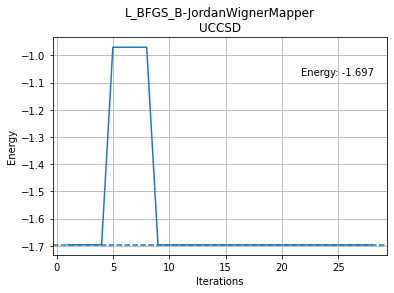

In [58]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']

energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.cost_function_evals,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.cost_function_evals,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f}).png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2o.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', 'rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', '# of qubits', '# of parameters', '# of CNOTs', '# of evaluations', 'error (mHa)']]

<div class="alert alert-block alert-danger">
    
<b>Tutorial questions 3</b> 

すべてのパラメーターを実験してから以下に答えてください：
    
1. 効率的な経験的試行波動関数を見つけられましたか？
2. `UCCSD, PUCCD, SUCCD`のansatzの中でベストなのはどれですか？
3. `UCCSD`を使ったときにベストなオプティマイザーはどれですか？
    
最も効率の良いansatzを探すには、精度、パラメーター数、最適化ステップ数、CNOTの数を考慮しなければならないことに注意してください。これらの質問は、議論のための質問で、成績はつきません。この答えについて、Slackチャンネルで自由に議論してください。

## Part 2: 水分子のqEOM

このパートでは、既に定義した水分子の励起状態を計算します。

qEOMをQiskitでソルバーとして使うために、最初に基底状態の計算を定義する必要があります。これを使って、qEOMソルバーは初期化できます：

In [12]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import GroundStateEigensolver, QEOM, VQEUCCFactory

# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
solver = VQEUCCFactory(quantum_instance)
gsc = GroundStateEigensolver(converter, solver)

# The qEOM algorithm is simply instantiated with the chosen ground state solver
qeom_excited_states_calculation = QEOM(gsc, "sd")

qeom_results = qeom_excited_states_calculation.solve(problem)

print(qeom_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -85.793115128954
  - computed part:      -1.779036581101
  - ActiveSpaceTransformer extracted energy part: -84.014078547853
~ Nuclear repulsion energy (Hartree): 9.819476509782
> Total ground state energy (Hartree): -75.973638619172
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -85.453836973254
> Total excited state energy (Hartree): -75.634360463471
  2: 
* Electronic excited state energy (Hartree): -85.433831988115
> Total excited state energy (Hartree): -75.614355478333
  3: 
* Electronic excited state energy (Hartree): -84.698027488745
> Total excited state energy (Hartree): -74.878550978963
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.86710004  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [1.88817012  0.00000001  0.0]
    - computed part:      [0.14243135  

<div class="alert alert-block alert-danger">
    
<b>Tutorial questions 4</b> 

厳密な励起状態のエネルギーを計算して、qEOMから得た結果と比べてください。(Coding)
    
見つかった違いについて、あなたの考えをSlackチャンネルに投稿してください。  
    
</div>

In [ ]:
# WRITE YOUR CODE BETWEEN THESE LINES - START



# WRITE YOUR CODE BETWEEN THESE LINES - END

## 追加情報

**Created by:** Ieva Liepuoniute and Pauline Ollitrault

**Version:** qiskit-nature 0.3.2